#Sentiment Analysis for Mental Health

In this project we are going to utilize *Roberta* model to perform the sentiment analysis on our Mental health dataset.

Its built on Pytorch + HuggingFace pipeline to perform sentiment analysis using Roberta Transformer.


#### Lets load the necessary libraries first to perform Data Cleaning, Data flitering and model building. I have used the following libraries :
- Pandas for data processing
- Sklearn for data spliting, to generate classifcation and confusion matrix for evaluation.
- Pytorch to build the model
- RobertaTokenizer for tokenization




In [ ]:
#!pip install transformers datasets scikit-learn torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_scheduler,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import Counter

##Data Loading:
- loaded the dataset to the notebook and displayed the first few rows for validation.


In [ ]:
dataframe = pd.read_csv("/content/MentalHealth_Data.csv")
dataframe.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


##Displaying the class distribution:

- There are totally 7 different sentiments mentioned in this dataset, and they are Normal, Depression, Suicidal, Anxiety, Bipolar, Stress and Personality disorder.

- In the column next to them you can see the counts of the respective class.

In [ ]:
print("\nClass Distribution:\n", dataframe["status"].value_counts())


Class Distribution:
 status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


## Data filtering :

- In this step we are dropping the rows with missing values in the statement, In the dataset the column is named as status.
- I have also dropped the rows with empty strings
- once the insignificant rows are dropped we would check our dataset to see if we having still missing values.

In [ ]:
print(f"Dataset size before dropping missing items: {len(dataframe)}")
dataframe = dataframe.dropna(subset=["statement", "status"])
dataframe = dataframe[~dataframe["statement"].str.strip().eq("")]
dataframe = dataframe[~dataframe["status"].str.strip().eq("")]

print(f"Dataset size after dropping missing items: {len(dataframe)}")
assert not dataframe["statement"].isnull().any(), "Still missing values in statement"
assert not dataframe["status"].isnull().any(), "Still missing values in status"

# Check for missing values
assert not dataframe["statement"].isnull().any(), "Missing values found in text column."
assert not dataframe["status"].isnull().any(), "Missing values found in emotion column."

Dataset size before dropping missing items: 53043
Dataset size after dropping missing items: 52681


## Encoding Sentiment labels and Data split:

- The sentiments in the dataset which are present in the status column are encoded into numeric values like 0, 1, 2...
- We divide the dataset into 70% train, 20% validation and 10% test.

In [ ]:
# Encoding labels
sentiment_labels = LabelEncoder()
dataframe["label"] = sentiment_labels.fit_transform(dataframe["status"])

# Data split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    dataframe["statement"],
    dataframe["label"],
    stratify=dataframe["label"],
    test_size=0.30,
    random_state=42,
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, stratify=temp_labels, test_size=0.333, random_state=42
)  # 0.333 of 30% = 10%

print(
    f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}"
)

Train size: 36876, Validation size: 10541, Test size: 5264


## Tokenization:
- Performed tokenization using Roberta Tokenizer.
- Roberta transformer can not understand our words. Hence, they need to be converted to tokens or numberical representation.
- By performing tokenization we are converting the sentences into a form that model understands.

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)
    return SentimentDataset(encodings, labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

## Batching:
- to enable batching across dataset I have defined the function SetimentDataset to wrap the tokenized data.

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        if hasattr(labels, "values"):
            self.labels = torch.tensor(labels.values, dtype=torch.long)
        else:
            self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

###Lets test the above function:

In [ ]:
# Lets take the second instance or row from the dataset to test our sentiment dataset action defined above to perform batching
sample_text = dataframe["statement"].iloc[1]
sample_label = dataframe["label"].iloc[1]
print(sample_text, sample_label)

# Tokenization
tokenized_input = tokenizer(
    [sample_text], truncation=True, padding=True, max_length=128
)
label_series = pd.Series([sample_label])

# Passing the Tokenized data to the SentimentDataset function defined above
sample_dataset = SentimentDataset(tokenized_input, label_series)
sample_output = sample_dataset[0]
print(sample_output)

trouble sleeping, confused mind, restless heart. All out of tune 0
{'input_ids': tensor([    0,    90,  8508,  5225,  8416,     6, 10985,  1508,     6, 36844,
         1144,     4,   404,    66,     9,  8859,     2]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor(0)}


- to enable smooth batch in the below code. I have called the tokenize_data function on train, validate and test dataset.
- the tokenized data are loaded into the using the built in function dataloader for efficient data loading during training and evaluation.

In [ ]:
train_dataset = tokenize_data(train_texts, train_labels)
val_dataset = tokenize_data(val_texts, val_labels)
test_dataset = tokenize_data(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

## Pretraining Roberta Model:
- The first line, we use GPU for faster computation else we go ahead with CPU.
- We load a powerful Roberta pretained transformer model and apply that to our sentiment classification task.
- AdamW : optimizes the model.
- Scheduler : adjusts the running rate as the training progresses


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", num_labels=len(sentiment_labels.classes_)
)
model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)
number_epochs = 3
num_training_steps = number_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# custom loss function
loss_function = nn.CrossEntropyLoss(weight=class_weights)

##Training:

In each epoch, we go through all the training batches, calculate the loss, bachpropagrate and update the model weights and print the average loss per epoch.

In [ ]:
def train():
    model.train()
    for epoch in range(number_epochs):
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss = loss_function(outputs.logits, batch["labels"])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        print(
            f"Epoch {epoch+1}/{number_epochs} - Loss: {total_loss/len(train_loader):.4f}"
        )

##Evaluation:

Here we evaluate the performance by predicting labels on the validate and test data, print classification report that includs F1 score, Recall and precision. finally plot the confusion matrix to visualize the mistakes.

In [ ]:
def evaluate(loader, mode="Validation"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())
    print(
        f"\n{mode} Classification Report:\n",
        classification_report(
            all_labels, all_preds, target_names=sentiment_labels.classes_
        ),
    )

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=sentiment_labels.classes_,
        yticklabels=sentiment_labels.classes_,
    )
    plt.title(f"{mode} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## Training and Evaluation:
Bringing all together...

calling the above defined functions to train and evaluate the Sentiment analysis model built.

(*NOTE* : Training and evaluation would take 45 to 50 mins to complete.)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1/3 - Loss: 0.6863
Epoch 2/3 - Loss: 0.4054
Epoch 3/3 - Loss: 0.2850

Validation Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.85      0.90      0.88       768
             Bipolar       0.83      0.85      0.84       556
          Depression       0.84      0.68      0.75      3083
              Normal       0.97      0.94      0.95      3270
Personality disorder       0.61      0.82      0.70       215
              Stress       0.67      0.87      0.76       518
            Suicidal       0.68      0.82      0.74      2131

            accuracy                           0.83     10541
           macro avg       0.78      0.84      0.80     10541
        weighted avg       0.84      0.83      0.83     10541



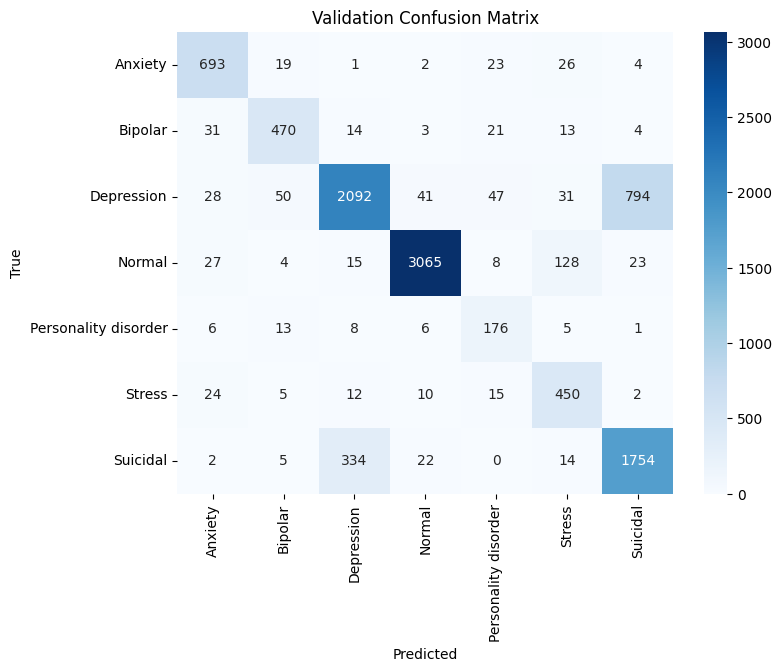

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Test Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.86      0.91      0.88       384
             Bipolar       0.87      0.87      0.87       277
          Depression       0.84      0.68      0.75      1539
              Normal       0.97      0.94      0.96      1633
Personality disorder       0.68      0.86      0.76       108
              Stress       0.68      0.88      0.76       258
            Suicidal       0.67      0.81      0.74      1065

            accuracy                           0.83      5264
           macro avg       0.80      0.85      0.82      5264
        weighted avg       0.84      0.83      0.83      5264



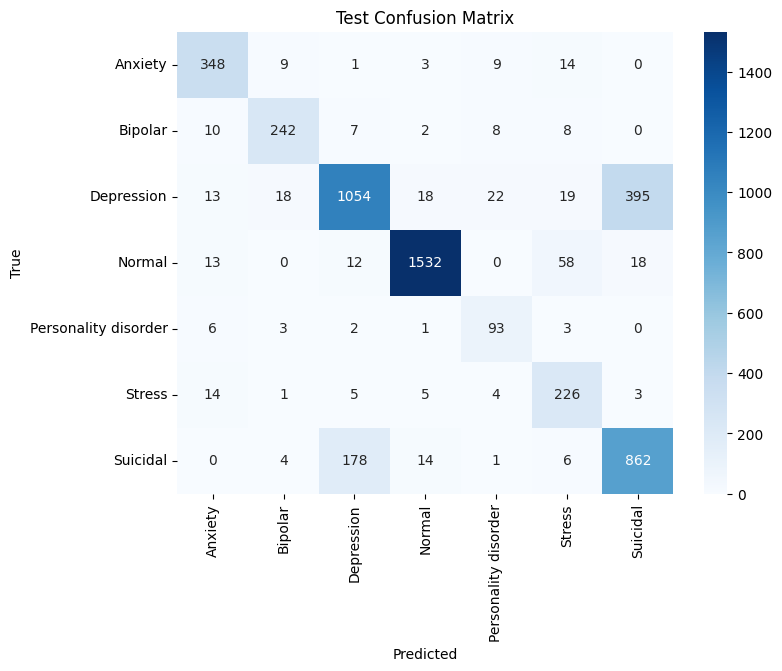

In [ ]:
train()
evaluate(val_loader, mode="Validation")
evaluate(test_loader, mode="Test")

##Testing the model over single sentence:

As the training and evaluation of model takles longer time ( about 50 mins ). Lets test the models performance using few sentences.

- As my tokenize_data function expects a dummy label , i'm passing [0] as the dummy label value for the sentence.


In [ ]:
# if unable to run the below function "single_sentence_testing" the possible required step would be to define the index_to_label. kindly uncomment this and rerun the below cell.
"""index_to_label = {
    0: "Normal",
    1: "Depression",
    2: "Stress",
    3: "Anxiety",
    4: "Bipolar",
    5: "Suicidal",
    6: "Personality disorder"
}"""

In [ ]:
def single_sentence_testing(text):
    model.eval()

    dummy_dataset = tokenize_data([text], [0])  # [0] = dummy label
    dummy_dataloader = DataLoader(dummy_dataset, batch_size=1)

    with torch.no_grad():
        for batch in dummy_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_class = torch.argmax(logits, dim=1).item()

    predicted_label = index_to_label[pred_class]
    print(f"Input: {text}")
    print(f"Predicted Sentiment Class: {predicted_label}")

In [ ]:
single_sentence_testing("I'm not worried about my exam results.")  # Expecting: Normal
single_sentence_testing("I’ve lost interest in everything.")  # Expecting: Anxiety
single_sentence_testing(
    "One moment I’m on top of the world, the next I want to disappear."
)  # Expecting: Bipolar

Input: I'm not worried about my exam results.
Predicted Sentiment Class: Normal
Input: I’ve lost interest in everything.
Predicted Sentiment Class: Anxiety
Input: One moment I’m on top of the world, the next I want to disappear.
Predicted Sentiment Class: Bipolar


In [ ]:
def piechat_visualization_function(loader):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            all_preds.extend(predictions.cpu().numpy())

    return all_preds

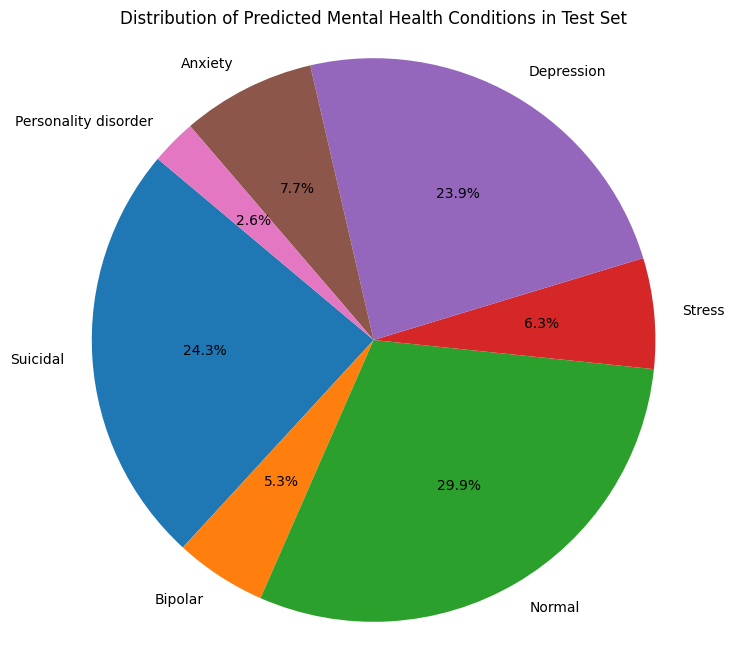

In [ ]:
# Get predictions on the test set
test_preds = piechat_visualization_function(test_loader)

# Decode to class names (if using LabelEncoder)
predicted_labels = sentiment_labels.inverse_transform(test_preds)

# Count occurrences
label_counts = Counter(predicted_labels)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    label_counts.values(), labels=label_counts.keys(), autopct="%1.1f%%", startangle=140
)
plt.title("Distribution of Predicted Mental Health Conditions in Test Set")
plt.axis("equal")  # Equal aspect ratio ensures pie is drawn as a circle.
plt.show()